#### Claribel Gonell
#### 705.603.82 - Creating AI Enabled Systems: Systems Project
#### 12/11/22

#### Using Sage Continuum's Sage Data Client API for Determing Population Density in the Chicago Loop 

### Background

SAGE (A Software-Defined Sensor Network Cyberinfrastructure for Edge Computing) is a project funded by the National Science Foundation that implements Waggle node design and aims to establish a national research infrastructure for geographically distributed sensor systems. These sensor systems also known as wild sage nodes consist of cameras, microphones, and weather sensors (measuring temperature, humidity and pressure). The wild sage node data is accessible via the Sage Data Client API and is hosted in the cloud. SAGE is currently deploying sensor nodes across the country and currently has environmental testbeds (both urban and rural)  in California, Colorado, Kansas, Illinois, and Texas. The open architecture design provides flexibility for assessing the environmental impacts of global urbanization, natural disasters, climate change and city infrastructure. 

The project (originally Array of Times(AoT)  launched in early 2019 with 130 nodes in Chicago however the original nodes retired in September 2021 however the archived data is still accessible. The original project  aimed to make it possible to assess the miro-environmental changes in Chicago which lends itself to a graph database design making it possible to observe “block-by-block” activity and provide further analysis of these changes.Therefore, the systems project aimed to evaluate the node data from 2019 through its retirement, however the AoT Data Archive (https://github.com/waggle-sensor/waggle/blob/master/data/README.md) Read Me has not been updated and the data files are different from the archive directory files making it difficult to manipulate the unpacked data archive. Additionally, the size of the archived data is 36 GB and several newer Waggle data tools are incompatible with archived data. Therefore for experimental purposes the systems project will assess more recent node data. 

The Chicago commercial real estate market has evidently experienced lower than average leasing activity since the COVID-19 pandemic. The original motivation of the project aimed to assess pedestrian and vehicle data during Non-Holiday Business Hours in Chicago’s Loop Area from the pre-Covid pandemic timeframe to present day in order to predict population density. This information could prove to be useful for assessing asset value as leasing activity continues to decline. Instead, the systems project deploys a machine learning model for classifying the currently active nodes from May - December. The experimental design serves as a benchmark for later data training. If successful, it may motivate the commercial real estate industry to consider funding for more nodes to be installed. 


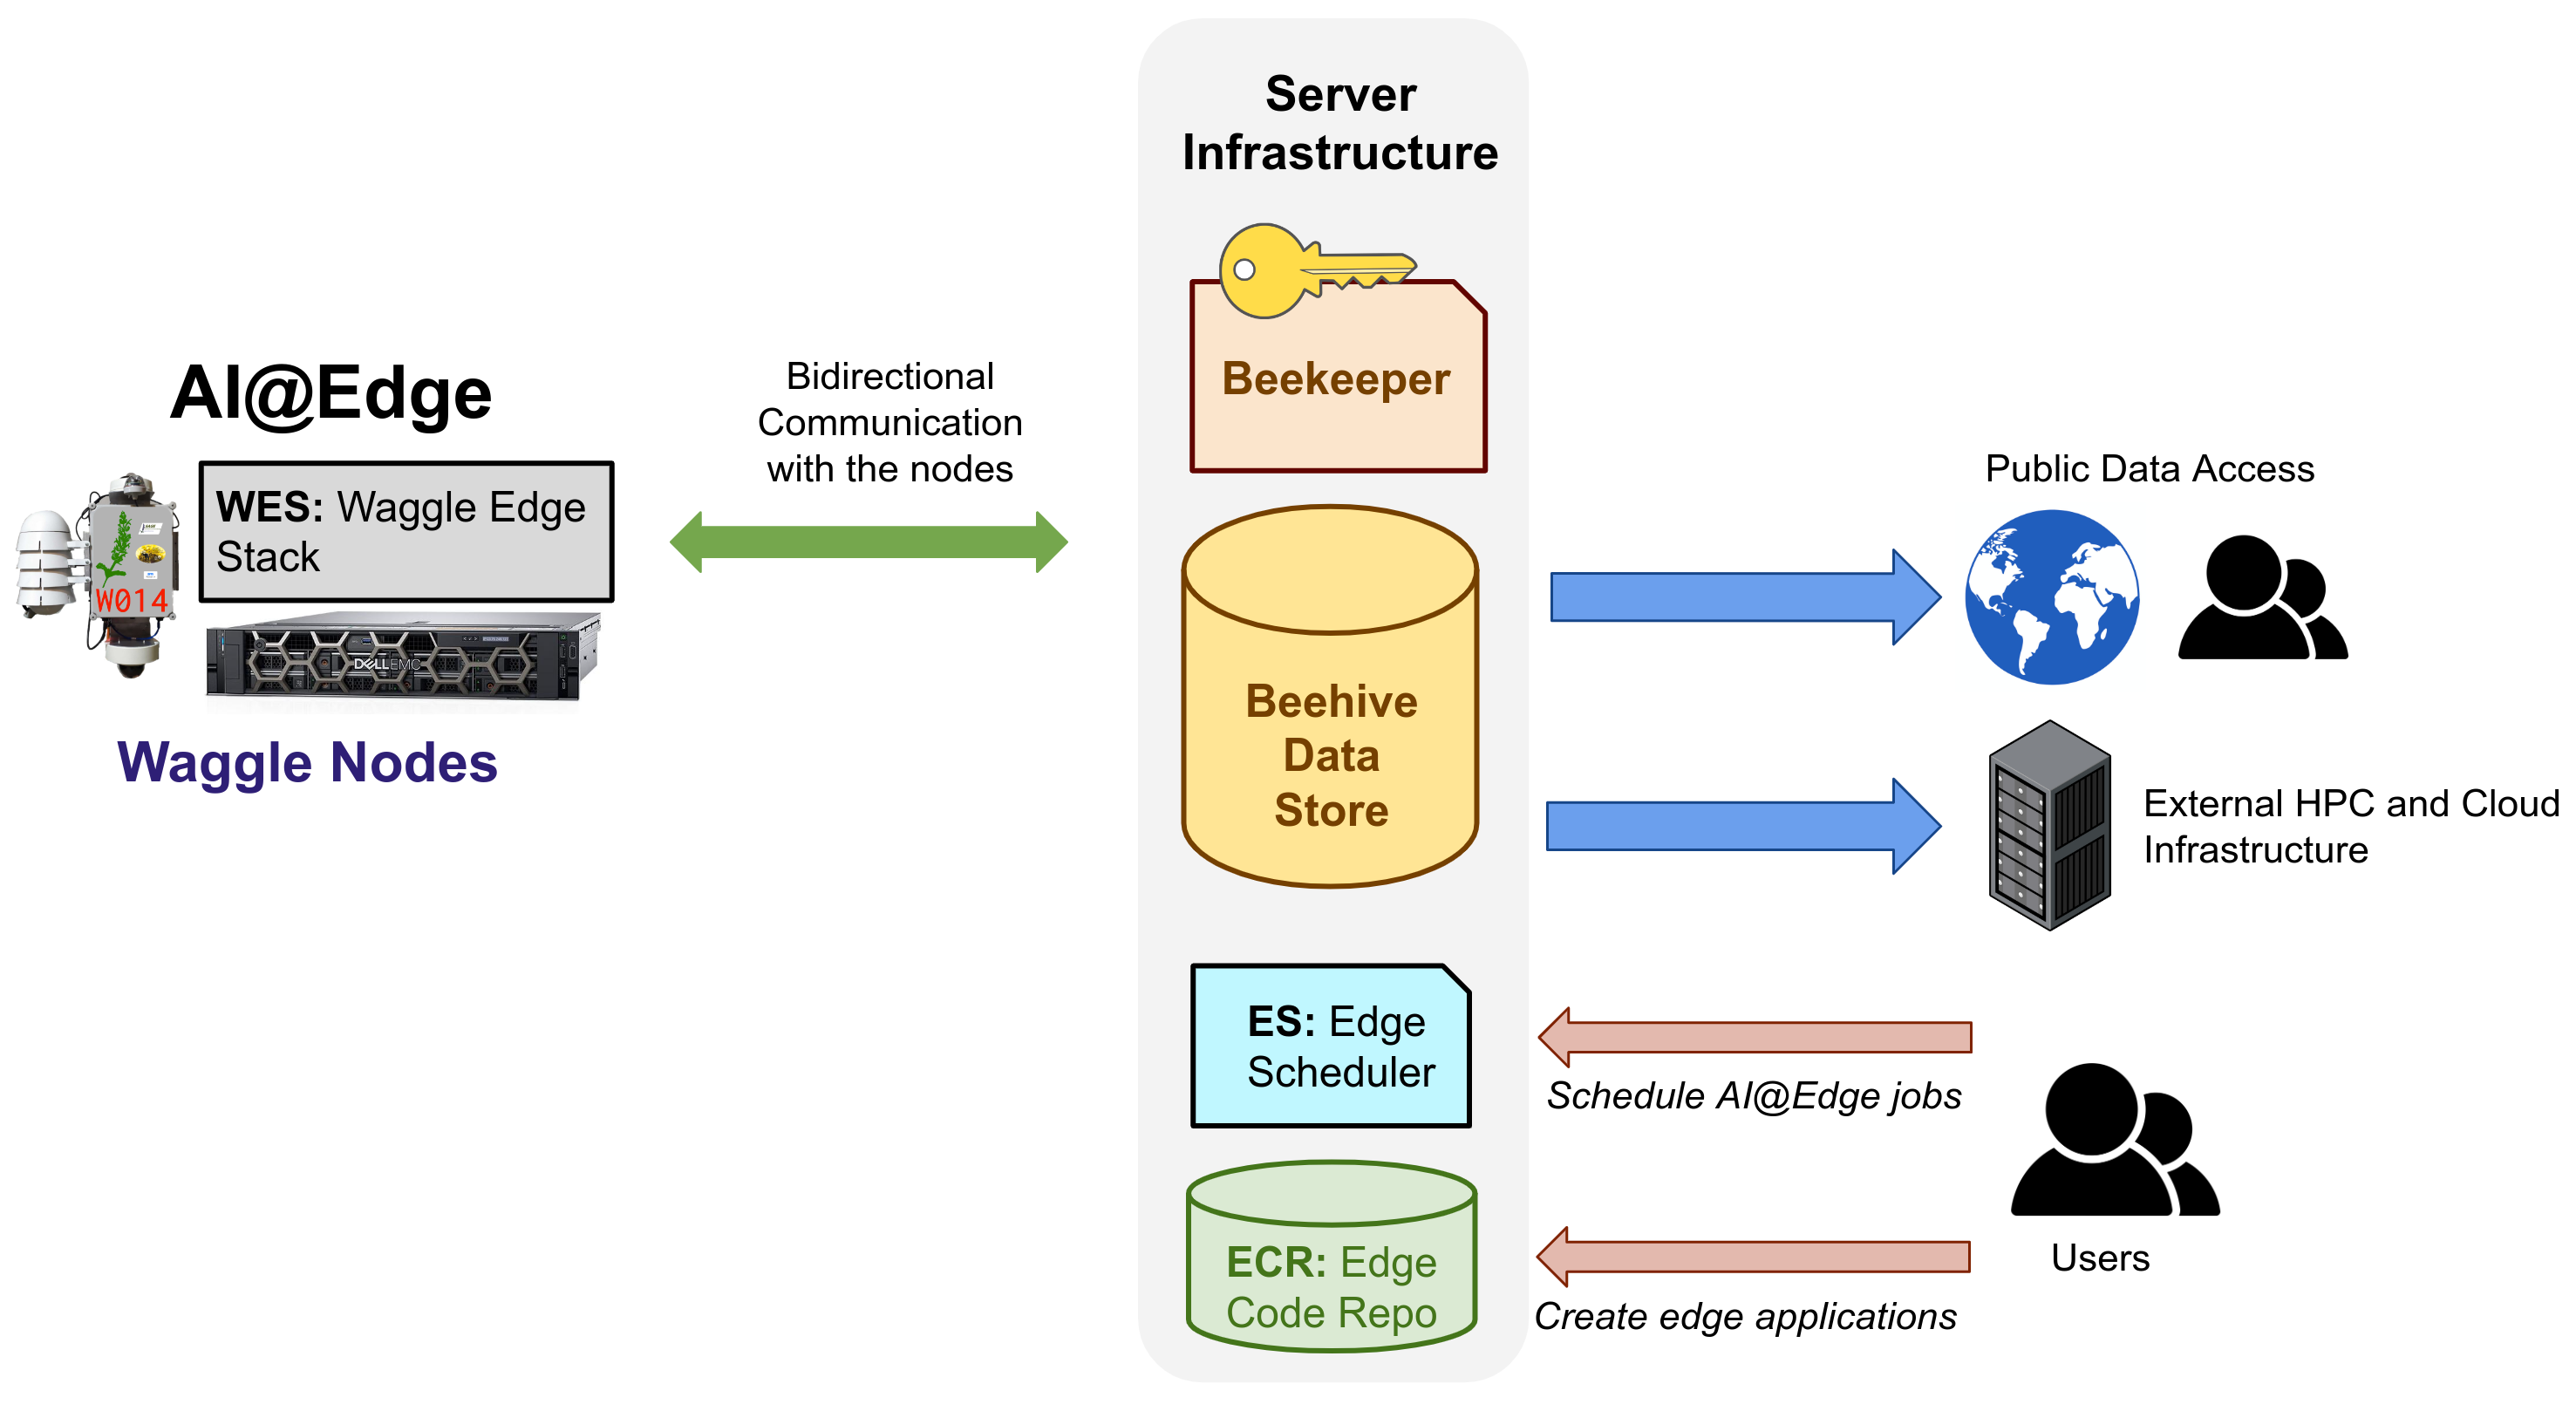

### Data

Since the Chicago Loop is the area of interest, data is collected for nodes that are in the Loop only. Currently, there are 5 Wild Nodes: W02C, W07A, W07B, W026, W079. Since the latest registration for these nodes occurred in May 2022, the Sage API client was queried for 05/22 - 12/22. The start time was calculated Time - 5/22/22 at 0:0:0 or 4,912 hours.  SAGE has published several open-source applications waggle plugins. The plugins used for data collection are Object Counter (https://github.com/waggle-sensor/plugin-objectcounter) and Traffic State (https://portal.sagecontinuum.org/apps/app/seonghapark/traffic-state). The data is queried and stored into a Pandas dataframe. The systems project will not be deploying a time series ML model and therefore the data time preprocessing is formatted to be compatible with linear regression. The month, day, year, hour, minute, and second is parsed before the categorical pre-processing phase. 

The data is pre-processed using an updated Categorical Preprocessing class. The nodes are mapped from 0-4 so that it may be used as the label column for model training. The object counter column, which consists of various objects classified by the YOLOv7 algorithm, is parsed by using dummy variables. Unrelated columns are dropped and the columns used for training are one hot-encoded. The columns considered are object counts for bicycles, buses, cars, motorbikes, motorcycles, and people. These object count columns are most representative of potential “commuter” data. The traffic state plugin data for averaged traffic speed is used gauging bottleneck slow periods may be indicative of busy or high traffic. 


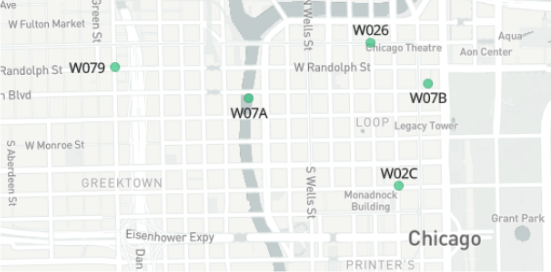

#### Wild Node W02C

Node Link: https://portal.sagecontinuum.org/node/000048B02D05A1C2 

Location: Jackson & South State, Chicago, IL

Registration: 5/18/2021 

Active Sensors: Temp, Humidity, Pressure

Data: Sound Event Detection, Motion-Detector, Image-Sampler, Object-Counter (additional plug ins)




#### Wild Node W07A

Node Link: https://portal.sagecontinuum.org/node/000048B02D3AE33B 

Location: North Upper Wacker and West Randolph, Chicago, IL

GPS (static): not available

Registration: 5/3/22

Active Sensors: Temp, Humidity, Pressure

Data: Sound Event Detection, Motion-Detector, Image-Sampler, Object-Counter (additional plug ins)



#### Wild Node W07B

Node Link: https://portal.sagecontinuum.org/node/000048B02D3AF41E 

Location:  North Michigan & East Randolph, Chicago, IL

GPS (static): 41.883778667, -87.625274667

Registration: 5/3/22

Active Sensors: Temp, Humidity, Pressure

Data: Sound Event Detection, Motion-Detector, Image-Sampler, Object-Counter (additional plug ins)



#### Wild Node W026

Node Link: https://portal.sagecontinuum.org/node/000048B02D05A1C7 

Location: Lake & North Dearborn, Chicago, IL

GPS (static): 41.88571217, -87.62955946

Registration: 5/19/2021

Active Sensors: Temp, Humidity, Pressure

Data: Sound Event Detection, Motion-Detector, Image-Sampler, Object-Counter (additional plug ins)



#### Wild Node W079

Node Link: https://portal.sagecontinuum.org/node/000048B02D3AE2D8 

Location: N. Halsted & West Randolph, Chicago, IL 

GPS (static):  41.884308025, -87.647484284

Registration: 5/2/22

Active Sensors: Temp, Humidity, Pressure

Data: Sound Event Detection, Motion-Detector, Image-Sampler, Object-Counter (additional plug ins)


### AWS Sagemaker Deployment

#### importing libraries and defining environment variables for ML deployment

In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # region instance

# auto-search for XGBoost image URI to build an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")


Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


#### S3 Bucket Creation 

In [2]:
bucket_name = 'cg-bucket4v7' 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)


S3 bucket created successfully


#### Initalize Python script files

In [3]:
!pygmentize src/data_processing.py

import sage_data_client
import pandas as pd

# query and load data into pandas data frame
w02C_traffic = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "traffic.state.*",
        "vsn": "W02C"
    }
)
w02C_envcount = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "env.count.*",
        "vsn": "W02C"
    }
)
w07A_traffic = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "traffic.state.*",
        "vsn": "W07A"
    }
)
w07A_envcount = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "env.count.*",
        "vsn": "W07A"
    }
)
w07B_traffic = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "traffic.state.*",
        "vsn": "W07B"
    }
)
w07B_envcount = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "env.count.*",
        "vsn": "W07B"
    }
)
w026_traffic = sage_data_client.query(
    start="-4912h",
    filter={
        "name": "traffic.

In [4]:
!pygmentize src/categorical_preprocessing.py

import pandas as pd


class Categorical_Preprocessing:
    def __init__(self):
        self.df = None

    def __getitem__(self, item):
        item = self.df
        return item

    def read_data(self, file_name: str):
        read = pd.read_csv(file_name)
        self.df = pd.DataFrame(read)
        return self.df

    def find_missing(self):
        missing = self.df.isnull().sum()
        return missing

    def data_type(self):
        data_type = self.df.dtypes
        return print(data_type)

    def missing_mean(self, col_name):
        self.df[col_name] = self.df[col_name].fillna(self.df[col_name].mean())
        return self.df

    def unique_values(self):
        unique_vals = {column: len(self.df[column].unique())
                       for column in self.df.columns if self.df.dtypes[column] == 'object'}
        return unique_vals

    def unique_col_vals(self, col_name):
        values_col = self.df[col_name].unique()
        return values_col

    def replace_mapping(sel

In [5]:
!pygmentize src/data_clean.py

import categorical_preprocessing as cp

sage = cp.Categorical_Preprocessing()
sage.read_data('api_data.csv')
sage.drop_columns(['timestamp', 'meta.host', 'meta.job',
                   'meta.node', 'meta.plugin', 'meta.task'])
sage.numeric('value')
maps = {'W02C': 0, 'W07A': 1, 'W07B': 2, 'W026': 3, 'W079': 4}
sage.replace_mapping(['nodes'], maps)
sage.unique_values()
sage.unique_col_vals('name')
sage.dummies('name')
sage.drop_columns(['name', 'env.count.aeroplane', 'env.count.airplane', 'env.count.apple',
                   'env.count.backpack', 'env.count.banana', 'env.count.bench',
                   'env.count.bird', 'env.count.boat', 'env.count.book', 'env.count.bottle',
                   'env.count.carrot', 'env.count.cat', 'env.count.cell_phone', 'env.count.chair',
                   'env.count.clock', 'env.count.cow', 'env.count.dog', 'env.count.elephant',
                   'env.count.fire_hydrant', 'env.count.giraffe', 'env.count.handbag',
                   'env.count.horse

In [6]:
!pygmentize src/model.py

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

model_data = pd.read_csv('data.csv', index_col=0)
X = model_data.drop(['nodes'], axis=1)
Y = model_data['nodes']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


#### Data loaded to Sagemaker instance

In [7]:
try:
  model_data = pd.read_csv('data.csv')
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


#### Shuffle and split data to training and test data (70/30)

In [8]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(268898, 15) (115242, 15)


In [9]:
pd.concat([train_data['nodes'], train_data.drop(['nodes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)


In [10]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

#### Define XGBoost model hyperparameters

In [11]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=10,eta=0.4,gamma=0.1,min_child_weight=6,subsample=1,num_round=100)


#### XGBoost model training job wtih gradient optimization on instance

In [12]:
xgb.fit({'train': s3_input_train})

2022-12-11 07:57:09 Starting - Starting the training job...
2022-12-11 07:57:36 Starting - Preparing the instances for trainingProfilerReport-1670745429: InProgress
............
2022-12-11 07:59:36 Downloading - Downloading input data...
2022-12-11 08:00:01 Training - Downloading the training image...
2022-12-11 08:00:35 Training - Training image download completed. Training in progress.Arguments: train
[2022-12-11:08:00:34:INFO] Running standalone xgboost training.
[2022-12-11:08:00:34:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-12-11:08:00:34:INFO] File size need to be processed in the node: 9.96mb. Available memory size in the node: 8635.26mb
[2022-12-11:08:00:34:INFO] Determined delimiter of CSV input is ','
[08:00:34] S3DistributionType set as FullyReplicated
[08:00:34] 268898x14 matrix with 3764572 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[08:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nod

### Analysis

In order to gauge the appropriate machine learning model for the data, I used Azure’s AutoML. The best model suggested was the XGBoost Classifier providing a 91% accuracy rate. The AutoML’s  top 4 features were month, value, day, and minute. I also trained and fit a XGBoost Classifier manually in a python script and deployed a XGBoost Classifier model using AWS Sagemaker. The local and cloud XGBoost Classifier models resulted in a ~76% accuracy rate. All three models used different train/test set splits. 

#### Model Deployment and Sagemaker endpoint created for access

In [13]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

--------!

#### Delete Endpoint

In [16]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

#### Delete training artifacts and S3 Bucket

In [17]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '81V5SV1ZVRSDQMAP',
   'HostId': 'GrE8E0FFWrdg0t5TMOG8xwwBpcLd7JHGs66J2yY/lX0tkmTNNZKp+i/IhxRN2J6M8Fx7ckXafgo=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'GrE8E0FFWrdg0t5TMOG8xwwBpcLd7JHGs66J2yY/lX0tkmTNNZKp+i/IhxRN2J6M8Fx7ckXafgo=',
    'x-amz-request-id': '81V5SV1ZVRSDQMAP',
    'date': 'Sun, 11 Dec 2022 11:54:54 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-12-11-07-57-09-613/profiler-output/system/incremental/2022121107/1670745540.algo-1.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-12-11-07-57-09-613/rule-output/ProfilerReport-1670745429/profiler-output/profiler-reports/OverallFrameworkMetrics.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-12-11-07-57-09-613/profiler-output/system/incremental/2022121108/1670745

### Findings

One of the possible shortcomings of my data pre-processing method is not removing data points for object-counts that were not considered. These object counts were still integral to the initial query of the sage client and may be necessary for appropriate training. Although the model was trained and deployed on Azure’s AutoML and AWS Sagemaker, I will be evaluating the performance based on the model created locally in Python. I used a manual test train split which resulted in a 75.76% and K-fold cross validation split with 5 folds and shuffling which resulted in a ~76% accuracy rate. The AWS Sagemaker XGB ranged between 72 - 75% accuracy. 

Another possible shortcoming with the model used is the need for more data. Since the AutoML feature importance suggests that month seems to be a critical factor for classifying the sage nodes for population density, the assumption is that weather needs to be considered. The sensor data was not considered since I wanted to look strictly at population; however it is evident that weather affects population density in general. Additionally, there is no real determination of why someone is downtown and if weather is important then there may be a correlation with peaks of tourism. Tourism was not considered due to the location of the nodes and where the popular attractions are. There may have been other possible object counts environments that may have been useful such as ties, backpacks, briefcases,etc to train the model to recognize "white collar/office setting employees", however this introduces un-necessary bias. If re-visited, sensor data and at least one calendar year’s worth of data needs to be evaluated in order to improve training accuracy. 

In terms of utility, commerical real estate can still benefit from investing in node funding (with the interest of appripriately distributed nodes and not placed specifically where assets are) as a more appropriate model can be fine-tuned and improved with more features related to weather and full calendar year observations.  


### Resources

Object Counter: 
https://github.com/waggle-sensor/plugin-objectcounter 

Traffic State: 
https://portal.sagecontinuum.org/apps/app/seonghapark/traffic-state 

YOLOv7: The Most Powerful Object Detection Algorithm 
https://viso.ai/deep-learning/yolov7-guide/ 

Array of Things
https://arrayofthings.github.io/index.html

Hands-On Computer Science: The Array of Things Experimental Urban Instrument
https://ieeexplore.ieee.org/abstract/document/9734773 

Sage Continuum
https://sagecontinuum.org/ 

Sage Continuum Portal
https://portal.sagecontinuum.org/nodes (related) 

Waggle@AI
https://docs.waggle-edge.ai/docs/about/overview 

Measuring Cities with Software-Defined Sensors
https://ieeexplore.ieee.org/abstract/document/9241512 

Waggle: An open sensor platform for edge computing
https://ieeexplore.ieee.org/abstract/document/7808975 

Making Sense of Sensor Data: How Local Environmental Conditions Add Value to Social Science Research
https://journals.sagepub.com/doi/abs/10.1177/0894439320920601 

Project Eclipse
https://www.microsoft.com/en-us/research/project/project-eclipse/ 

SAGE: A Software-Defined Sensor Network SAGE
https://www.anl.gov/mcs/sage-a-softwaredefined-sensor-network 
